##***Stanford Dogs Classification Using CNNs***

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, \
                Flatten, MaxPooling2D, BatchNormalization, Dropout, \
                RandomFlip, RandomRotation, RandomZoom, Resizing, Input, \
                Rescaling, GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam, SGD

import tensorflow_datasets as tfds

from matplotlib import pyplot as plt, gridspec as gridspec
from random import randint
import numpy as np

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
tf.__version__, tf.config.list_physical_devices('GPU')

('2.15.0', [])

#***prepare to visualise dataset***

In [ ]:
num_classes = 120
input_shape = (224, 224, 3)
batch_size = 16

***Let's first load the data and split it into the training images and their labels, and testing images and their labels***

In [ ]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'StanfordDogs',
    split=['train[:80%]', 'train[80%:]', 'test'],
    with_info=True,
    as_supervised=False,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteCUEQ95/stanford_dogs-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteCUEQ95/stanford_dogs-test.tfrecord*...:   0%…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


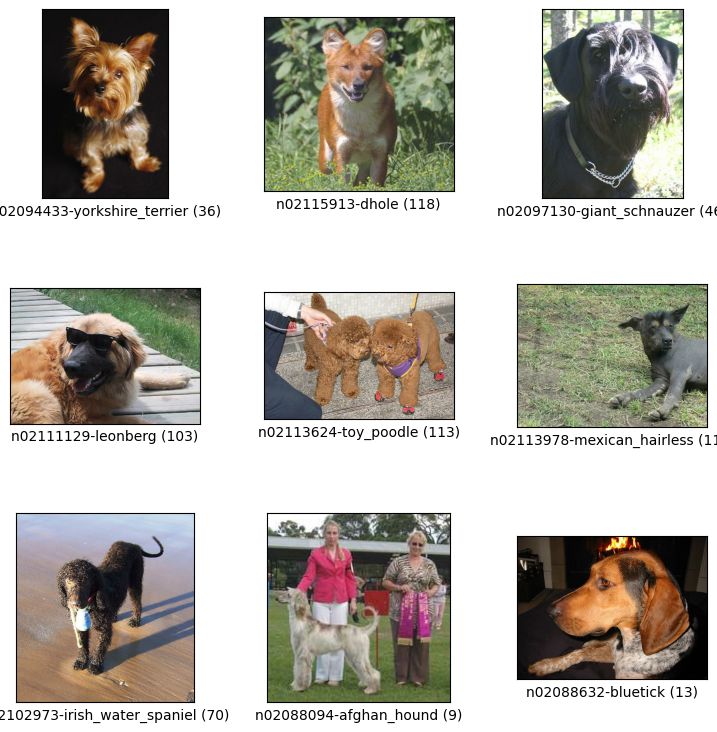

In [ ]:
fig = tfds.show_examples(train_ds, metadata)

*We will crop the dogs using the first bounding box\
Note we could also try without cropping to see the effect on training and testing performance. There is likely to be a trade-off here, cropping will ensure we're training the model on dogs only, but at inference time we are unlikely to get images cropped nearly around the dogs

In [ ]:
def preprocess(ds_row):
    image = tf.expand_dims(
        tf.image.convert_image_dtype(ds_row['image'], dtype=tf.float32), axis=0
    )
    label = ds_row['label']
    bboxes = ds_row['objects']['bbox']

    # Note this is getting the first dog in the image only if there are multiple dogs
    box_indices = tf.zeros(tf.shape(bboxes)[0], tf.int32)
    images = tf.image.crop_and_resize(
        image,
        bboxes,
        box_indices,
        crop_size=(224, 224),
    )
    return images[0], label

In [ ]:
aug_train_ds = train_ds.map(
    lambda ds_row: preprocess(ds_row)
)

aug_val_ds = val_ds.map(
    lambda ds_row: preprocess(ds_row)
)

##***Visualize the dataset***

In [ ]:
def visualize_predictions(dataset, model=None, number_of_samples=4):
# dataset = aug_train_ds
# number_of_samples = 4
# model = None

    img_batch = dataset.take(number_of_samples)
    pred_batch = model.predict(img_batch) if model else None

    print(img_batch)
    images = np.array([i[0] for i in img_batch])
    preds = np.array([p for p in pred_batch]) if pred_batch is not None else np.ones_like(images)

    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1)

    for i in range(2):
        innerGrid = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outerGrid[i], wspace=0.05, hspace=0.05)

        for j in range(4):
            ax = plt.Subplot(fig, innerGrid[j])
            if (i == 1):
                ax.imshow(preds[j])
            else:
                ax.imshow(images[j])

            ax.axis('off')
            fig.add_subplot(ax)

    plt.show()


<_TakeDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


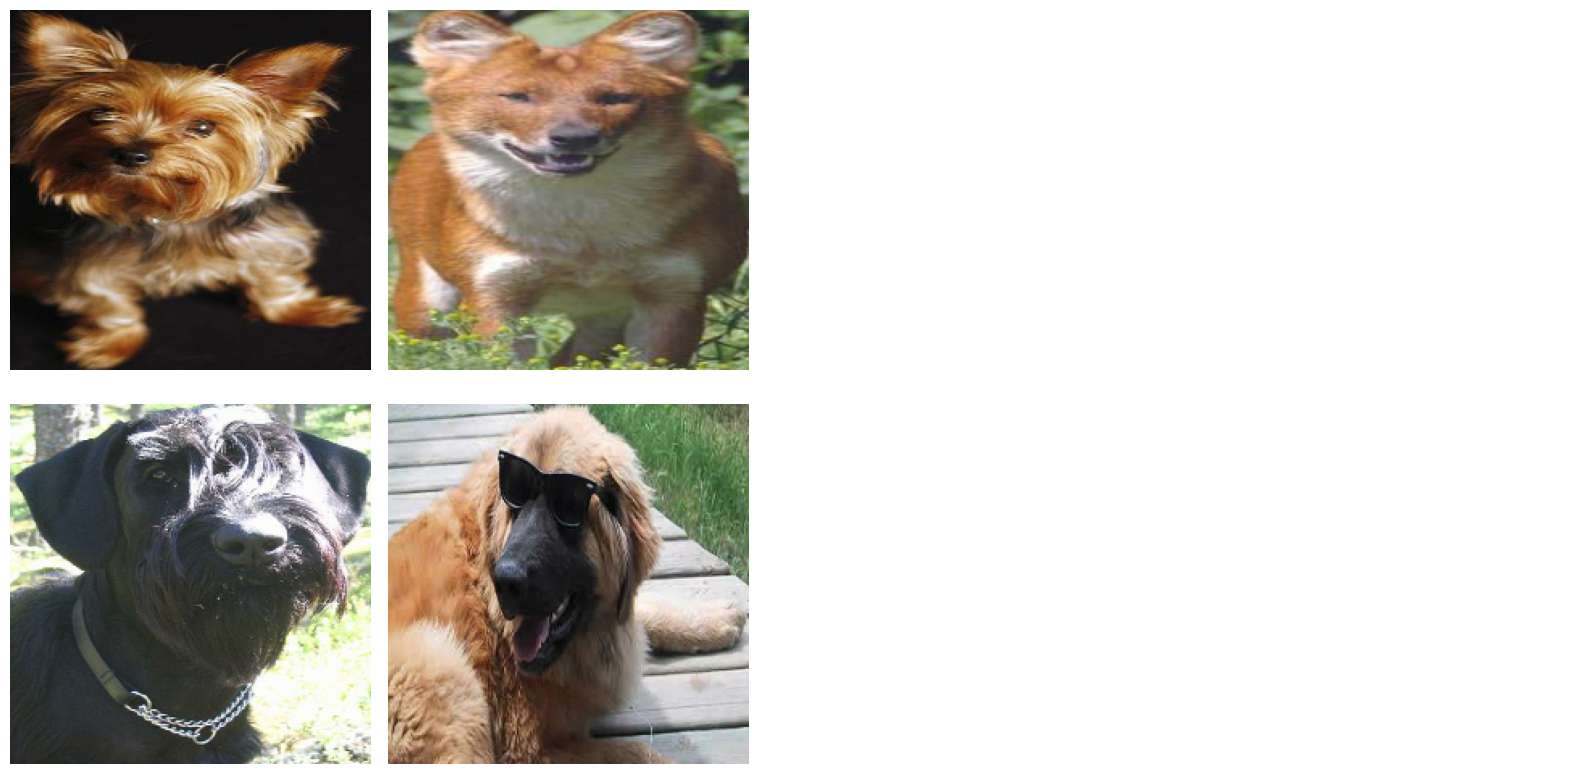

In [ ]:
visualize_predictions(aug_train_ds)

##Building the Model
To remind you, a CNN model looks like this: Input ==> conv ==> pooling ==> flatten into 1D ==> dense ==> output

In [ ]:
base_model = tf.keras.applications.efficientnet.EfficientNetB0(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False,
    classes=num_classes)

16705208/16705208 [==============================] - 0s 0us/step


Note: each Keras Application expects a specific kind of input preprocessing. For EfficientNet, input preprocessing is included as part of the model (as a Rescaling layer), and thus tf.keras.applications.efficientnet.preprocess_input is actually a pass-through function. EfficientNet models expect their inputs to be float tensors of pixels with values in the [0-255] range.

In [ ]:
inputs = Input(shape=input_shape)
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                             

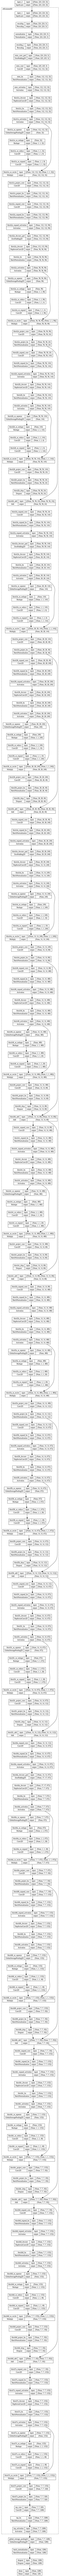

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
)

#***configure callback***

In [ ]:
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_on_plateau = callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr= 1e-6, verbose=1)

#Compile the model
We use adam as an optimizer and sparse categorical cross entropy for loss.

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', ],

)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                             

##Testing and evaluating

In [ ]:
# Train the model
history = model.fit(
    aug_train_ds,
    epochs=15,
    validation_data=aug_val_ds,
    callbacks=[reduce_on_plateau]
)

Epoch 1/15


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(224, 224, 3)


In [ ]:
hist = history.history
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.plot(history.epoch, hist['accuracy'], label='Train Accuracy')
plt.plot(history.epoch, hist['val_accuracy'], label = 'Val Accuracy')
plt.legend()

##***Evaluate model performance***

In [ ]:
aug_test_ds = test_ds.map(
    lambda ds_row: preprocess(ds_row)
)

In [ ]:
model.evaluate(aug_test_ds.batch(batch_size))

##***Save the trained model***

In [ ]:
model.save('stanford-dogs-efficientnet')

##***Predict using the trained model and render confusion matrix***

In [ ]:
preds = np.array(tf.math.argmax(model.predict(aug_test_ds.batch(batch_size)), axis=1))

test_labels = [y for x, y, in aug_test_ds]
test_labels

import pandas as pd
conf_matrix = np.array(tf.math.confusion_matrix(
    test_labels,
    preds
))

In [ ]:
import seaborn as sns
plt.figure(figsize=(20,15))
sns.heatmap(conf_matrix)
plt.ylabel('True label')
plt.xlabel('Predicted label')